## Importing Neccesary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
a = pd.read_csv("Medical cost Dataset.csv")
a.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
a.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
print(a.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


We can observe here that null values are not there.

In [6]:
print(a.duplicated().sum())
a[a.duplicated()]
a = a.drop_duplicates()
print(a.duplicated().sum())
#  Duplicate rows were identified and removed

1
0


Encoding 

In [7]:
a['region'].value_counts()
a['sex'] = a['sex'].map({'male': 0, 'female': 1})
a['smoker'] = a['smoker'].map({'no': 0, 'yes': 1})
a = pd.get_dummies(a, columns=['region'], drop_first=True).astype(int)
a.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,1,27,0,1,16884,0,0,1
1,18,0,33,1,0,1725,0,1,0
2,28,0,33,3,0,4449,0,1,0
3,33,0,22,0,0,21984,1,0,0
4,32,0,28,0,0,3866,1,0,0


outliers checking and Handling

In [8]:
#  Checking how many outliers are present in each numeric column in each numeric column
numerical_cols = a.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    Q1 = a[col].quantile(0.25)
    Q3 = a[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = a[(a[col] < lower) | (a[col] > upper)]

    print(f"{col}: {len(outliers)} outliers")

age: 0 outliers
sex: 0 outliers
bmi: 9 outliers
children: 0 outliers
smoker: 274 outliers
charges: 139 outliers
region_northwest: 324 outliers
region_southeast: 0 outliers
region_southwest: 325 outliers


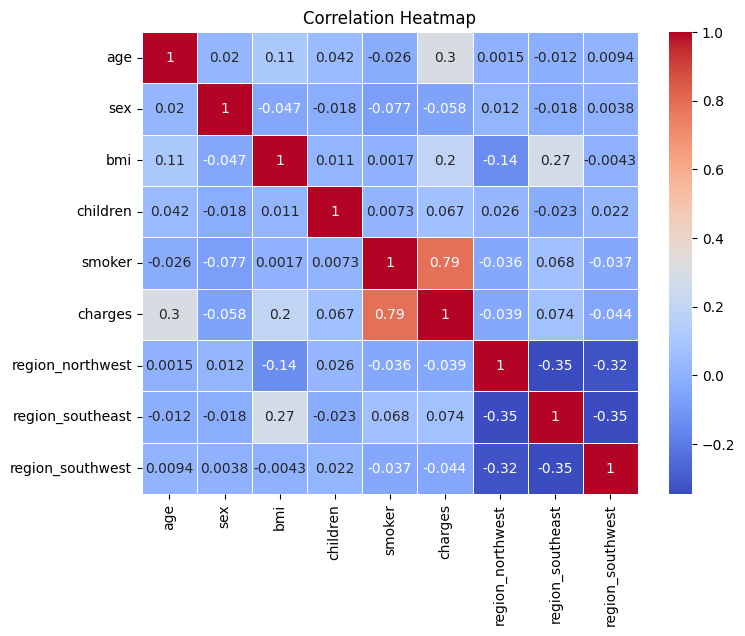

In [9]:
# Calculate correlation matrix
corr = a.corr(numeric_only=True)  # Only numerical columns

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

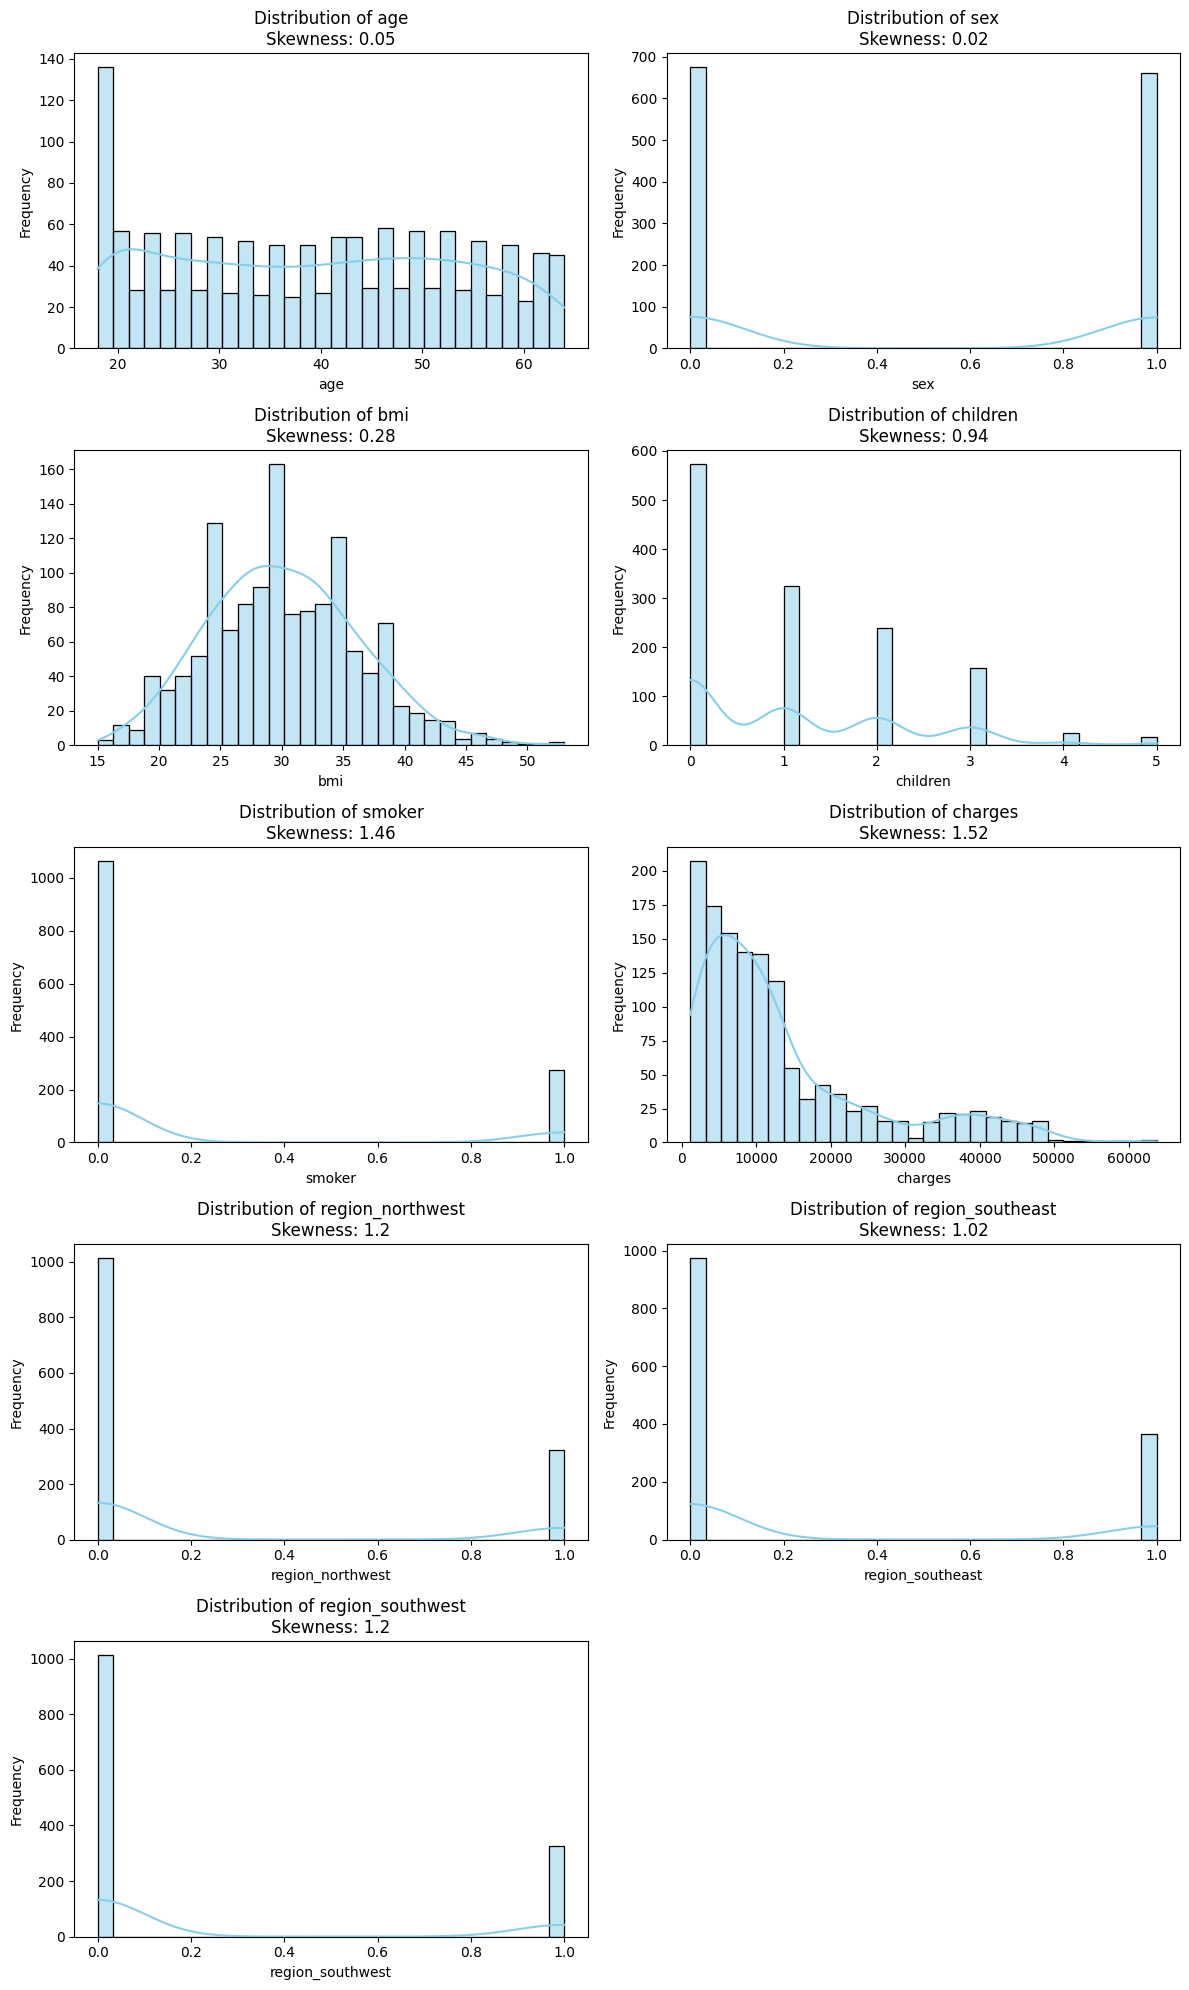

In [10]:
numerical_cols = a.select_dtypes(include=['int64', 'float64']).columns
n_cols = 2
n_rows = (len(numerical_cols) + 1) // n_cols

plt.figure(figsize=(12, 4 * n_rows))

for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(a[col], kde=True, bins=30, color='skyblue')
    skew_val = round(a[col].skew(), 2)
    plt.title(f'Distribution of {col}\nSkewness: {skew_val}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Note: charges and bmi show noticeable positive skewness, indicating a long right tail in their distributions. These columns have extreme high values, likely contributing to the skew.
Features like age and children are fairly symmetric, with skewness values close to zero.
Categorical or binary features (e.g., smoker, region_*) that were one-hot encoded may falsely appear skewed due to their limited values (0 and 1 only). However, this is not meaningful skewness, and no transformation is needed for them

In [11]:
# Outlier Handling
def cap_outliers_iqr(a, column):
    Q1 = a[column].quantile(0.25)
    Q3 = a[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    a[column] = a[column].apply(
        lambda x: lower if x < lower else upper if x > upper else x)


columns_to_fix = ['bmi', 'charges']

for col in columns_to_fix:
    cap_outliers_iqr(a, col)

print(" Outliers fixed safely using IQR capping for:", columns_to_fix)

 Outliers fixed safely using IQR capping for: ['bmi', 'charges']


Note: No outlier treatment is applied to 'smoker' and 'region_*' columns
because they are binary (0 or 1) categorical variables.
The IQR method may falsely identify outliers due to class imbalance or low variance,
but these are not true outliers.
Outlier treatment is only applied to continuous numerical features like 'bmi' and 'charges'.


Note: Normalization was not applied because Random Forest Regressor is a tree-based model that is not affected by feature scaling.
Instead, focus was given to proper encoding and outlier treatment.

# MODEL BUILDING

In [12]:
X = a.drop('charges', axis=1)
y = a['charges']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)


rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))


mae = mean_absolute_error(y_test, y_test_pred)


print("Model Evaluation:")
print(f"Training Accuracy : {train_r2 * 100:.2f}%")
print(f"Testing Accuracy  : {test_r2 * 100:.2f}%")
print(f"Testing RMSE          : {rmse:.2f}")
print(f"Mean Absolute Error (MAE): ₹{mae:.2f}")

Model Evaluation:
Training Accuracy : 96.57%
Testing Accuracy  : 83.65%
Testing RMSE          : 4370.67
Mean Absolute Error (MAE): ₹2347.32


Note: 
Training  of 96.57% indicates that the model fits the training data very well.
Testing  of 83.65% shows good generalization and high predictive performance on unseen data.
RMSE of ₹4370.67 suggests that on average, the model's predictions deviate by about ₹4370 from the actual insurance charges — acceptable given the range of charge

In [13]:
import pickle

with open('medical_model.pkl', 'wb') as file:
    pickle.dump(model, file)